# Britain and UK Handbooks as Data

Created in July and August 2020 for the National Library of Scotland's Data Foundry by Lucy Havens, Digital Library Research Intern

### About the *Britain and UK Handbooks* Dataset
The data consists of digitized text from select Britain and UK Handbooks produced between 1954 and 2005.  A central statistics bureau produced the Handbooks each year to communicate information about the UK that would impress international diplomats.
* Data format: digitized text
* Data creation process: Optical Character Recognition (OCR)
* Data source: https://data.nls.uk/digitised-collections/britain-uk-handbooks/

Time Permitting: extract and display covers???

### 0. Preparation
Import libraries to use for cleaning, summarizing and exploring the data:

In [12]:
# To prevent SSL certificate failure
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Libraries for data loading
import pandas as pd
import numpy as np
import string
import re

# Libraries for visualization
import altair as alt
import matplotlib.pyplot as plt

# Libraries for text analysis
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
nltk.download('tagsets')  # part of speech tags
from nltk.draw.dispersion import dispersion_plot as displt

[nltk_data] Downloading package punkt to /Users/lucy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


The nls-text-handbooks folder (downloadable as *Just the text* data from the website at the top of this notebook) contains TXT files of digitized text, with numerical names, as well as a CSV inventory file and a TXT ReadMe file.  Load only the TXT files of digitized text and **tokenize** the text (which splits a string into separate words and punctuation):

In [13]:
corpus_folder = 'data/nls-text-handbooks/'
wordlists = PlaintextCorpusReader(corpus_folder, '\d.*', encoding='latin1')
corpus_tokens = wordlists.words()
print(corpus_tokens[:10])

['BRITAIN', '1979', '3W', '+', 'L', 'Capita', '!', 'Edinburgh', 'Population', '5']


It's hard to get a sense of how accurately the text has been digitized from this list of 10 tokens, so let's look at one of these words in context.  To see phrases in which "Edinburgh" is used, we can use the concordance() method:

In [14]:
t = Text(corpus_tokens)
t.concordance('Edinburgh', lines=20)

Displaying 20 of 2579 matches:
BRITAIN 1979 3W + L Capita ! Edinburgh Population 5 , 196 / GOO ENGLAND A
ondon WC1V 6HB 13a Castle Street , Edinburgh EH2 3AR 41 The Hayes , Cardiff CF1
ield Liverpool Manchester Bradford Edinburgh Bristol Belfast Coventry Cardiff s
Counsellors of State ( the Duke of Edinburgh , the four adult persons next in s
ments , accompanied by the Duke of Edinburgh , and undertakes lengthy tours in 
y government bookshops in London , Edinburgh , Cardiff , Belfast , Manchester ,
five Scottish departments based in Edinburgh and known as the Scottish Office .
 is centred in the Crown Office in Edinburgh . The Parliamentary Draftsmen for 
. The main seat of the court is in Edinburgh where all appeals are heard . All 
 The Court of Session sits only in Edinburgh , and has jurisdiction to deal wit
ersities are : Aberdeen , Dundee , Edinburgh , Glasgow , Heriot - Watt ( Edinbu
nburgh , Glasgow , Heriot - Watt ( Edinburgh ), St . Andrews , Stirling , and S
. Andrews , Gla

I'm guessing `bife` should be `Fife` as it's closely followed by `Dundee`, but overall not so bad!

We can also load individual files from the nls-text-handbooks folder:

In [15]:
file = open('data/nls-text-handbooks/205336772.txt', 'r')
sample_text = file.read()
sample_tokens = word_tokenize(sample_text)
sample_sents = sent_tokenize(sample_text)
print(sample_tokens[:10])
print()
print(sample_sents[:5])
# print(sample_sents[-5:])

['GH', '.', 'fl-', '[', 'IASG0', '>', 'J^RSEI', 'nice', ']', 'ROME']

['GH.', 'fl-\n[IASG0>\nJ^RSEI\nnice]\nROME\nGIBRALTARi\n[NICOSIA\nTRIPOLI\nCAIRO)\n[KUWAIT\nBAHREIN\nXUTTA\nHONG KONG\nBOMBAY!', ".DAKAR\nLgambia\nRANGO(\nKHARTOUM I\nADEN\nBANGKOI\nbfrbI\nrPREETOVVN i'i'V L\nHARGEISA\nCOLOMBO’\nLABUANi\n^CCRA\nMogadishu\nENTEBI\n.SINGAI\n[ROBl\nDJAKARTA*\nlivingstoJB\nMAURITIUS\nJOHANNESBURG^\noS3\nCL\nsou\nT H E R N\nROUTES OPERATED By BRITISH OVERSEAS AIRWAYS-BRITISH EUROPEAN AIRWA YS- TRANS-CANADA AIR LINES -Q ANT AS EMPIRE AIRWAYS I\nMain Commonwealth Air Routes\nAugust 1954\nGLASG<\nEDMONTON,\nWINNIPEG\nVANCOI\nCALGAR1\njersey:\nAIONTREAI\nToronto'\nCHICAGO!", 'SAN FRANC ISC<\nGIBRALTAR!', '[BERMUDA\nHONOLULU)\nGRAND CAYMAN\nDAKAR!']


However, in this Notebook, we're interested in the entire dataset, so we'll use all its files.  Let's find out just how many files, and just how much text, we're working with:

In [16]:
def corpusStatistics(plaintext_corpus_read_lists):
    total_chars = 0
    total_words = 0
    total_sents = 0
    total_files = 0
    for fileid in plaintext_corpus_read_lists.fileids():
        total_chars += len(plaintext_corpus_read_lists.raw(fileid))
        total_words += len(plaintext_corpus_read_lists.words(fileid))
        total_sents += len(plaintext_corpus_read_lists.sents(fileid))
        total_files += 1
    print("Total...")
    print("  Characters in Handbooks Data:", total_chars)
    print("  Words in Handbooks Data:", total_words)
    print("  Sentences in Handbooks Data:", total_sents)
    print("  Files in Handbooks Data:", total_files)

corpusStatistics(wordlists)

Total...
  Characters in Handbooks Data: 90573254
  Words in Handbooks Data: 16606800
  Sentences in Handbooks Data: 584618
  Files in Handbooks Data: 50


Across the 50 files that make up the Handbooks dataset, there are over 90 million characters (which could be words, numbers, punctuation, abbreviations, etc.), over 16 million words, and nearly 600,000 sentences.  Of course, OCR isn't perfect, so these numbers are estimates, not precise totals.

Variables that store the characters, words, and sentences in our dataset will be useful for future analysis.  Let's create those now:

In [17]:
def getCharsWordsSents(plaintext_corpus_read_lists):
    all_chars = []
    all_words = []
    all_words_lower = []
    all_sents = []
    for fileid in plaintext_corpus_read_lists.fileids():
        
        file_chars = plaintext_corpus_read_lists.raw(fileid)
        all_chars += [str(char).lower() for char in file_chars]
        
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words_lower += [str(word).lower() for word in file_words if word.isalpha()]
        all_words += [str(word) for word in file_words  if word.isalpha()]
        
        file_sents = sent_tokenize(plaintext_corpus_read_lists.raw(fileid))  #plaintext_corpus_read_lists.sents(fileid)
        all_sents += [str(sent) for sent in file_sents]
        
    return all_chars, all_words, all_words_lower, all_sents
        
handbooks_chars, handbooks_words, handbooks_words_lower, handbooks_sents = getCharsWordsSents(wordlists)

In [18]:
print(handbooks_chars[:10])
print(handbooks_chars[-10:])
print()
print(handbooks_words[:10])
print(handbooks_words[-10:])
print()
print(handbooks_words_lower[:10])
print(handbooks_words_lower[-10:])
print()
sample_sentences = handbooks_sents[:10] + handbooks_sents[-10:]
for s in sample_sentences:
    # remove new lines and tabs at the start and end of sentences
    s = s.strip('\n')
    s = s.strip('\t')
    # remove new lines and tabs in the middle of sentences
    s = s.replace('\n','')
    s = s.replace('\t','')
    print(s)

['b', 'r', 'i', 't', 'a', 'i', 'n', ' ', '1', '9']
['o', 'r', 'e', 's', 'b', 'y', '%', 't', '\r', '\n']

['BRITAIN', 'L', 'Capita', 'Edinburgh', 'Population', 'GOO', 'ENGLAND', 'Area', 'km', 'miles']
['AIRWAYS', 'ADEN', 'ALWAYS', 'BAHAMAS', 'AIRWAYS', 'ASSOCIATES', 'August', 'r', 'MORESBY', 'T']

['britain', 'l', 'capita', 'edinburgh', 'population', 'goo', 'england', 'area', 'km', 'miles']
['airways', 'aden', 'always', 'bahamas', 'airways', 'associates', 'august', 'r', 'moresby', 't']

Capita! 1979
Capita!q.miles.kmGOO
^xt:. i - <1.. i 'i&rr
u.
(between pp 390 and 391).t structure390);olomgssalaries
Central Office of Information. by Reference Division of thees
information available up to September 1 978.
Information Services in many countries.ovided by the British
Stationery Office throughout the world.n sale by Her Majesty's
part played by government in the life of the country. thethe
Island.fijtle
dergus _B.
)allycpnnÂ«in.P!
sasdebellingham.eet(Distances
BOMBAY!NG^ George Philip A So

### 1. Data Cleaning and Standardization

`bife` most likely isn't the only word the OCR incorrectly digitized.  To get a sense of how much of the digitized text we can perform meaningful analysis on, let's figure out how many of NLTK's "words" are actually recognizable English words.

We'll use [WordNet](https://wordnet.princeton.edu/),* a database of English words, to evaluate which of NLTK's "words" are not valid English words.

***

  *Princeton University "About WordNet." WordNet. Princeton University. 2010.

**First,** let's create a list of strings from the words NLTK has identified for us:

In [19]:
str_tokens = [str(word) for word in corpus_tokens]
assert(type(str_tokens[0]) == str)  # quick test to make sure the output is as expected
print(str_tokens[0:10])

['BRITAIN', '1979', '3W', '+', 'L', 'Capita', '!', 'Edinburgh', 'Population', '5']


There are digits and punctuation that won't be recognized as words in WordNet but still provide valuable text data for studying the Handbooks.  For example, in the output above, it looks as though the OCR processed the word `Capital` as `Capita!`, which NLTK has split into two.  Furthermore, the word '1979' is a date that puts the text in context, which would enable one to order information in the text by date.

To get an estimate of how accurately OCR digitized the Handbooks, though, we'll use words in the sense that they are recognizable words in the English language.  Let's write a regular expression that can tell us whether a string is a word or abbreviation:

In [20]:
isWord = re.compile('[a-zA-z.]+')  # include single letters and abbreviations

# ----------- TESTING REGEX -----------
# print(isWord.match("bife").group())
# print(isWord.match("U.S.A.").group())
# print(isWord.match("W").group())
# print(isWord.match("1979") == None)

**Lastly,** let's use that regular expression to write a function to distinguish words recognizable English words from unrecognizable strings:

In [2]:
#########################################################################
# TRY MAPPING UNKNOWN WORDS TO UNK POS TO HELP CLEAN TEXT WITH BACKOFF?
# https://www.nltk.org/book/ch05.html
#########################################################################



def removeNonEnglishWords(list_of_strings):
    english_only = []
    nonenglish = []
    for s in list_of_strings:
        test = isWord.match(s)            # fails if has characters other than letters or a period
        if (test != None):
            passed = test.group()   # get the matching string
            if wordnet.synsets(passed):  # see if WordNet recognizes the matching string
                english_only.append(passed)
            else:
                nonenglish.append(passed)
        else:
            nonenglish.append(passed)
    return english_only, nonenglish
                
recognized, unrecognized = removeNonEnglishWords(str_tokens)

In [22]:
print("Total alphabetic words recognized in WordNet:", len(recognized))
print("Total alphabetic words NOT reccognized in WordNet:", len(unrecognized))
print("Percentage of alphabetic words that are unrecognized in WordNet:", (len(unrecognized)/len(recognized))*100, "%")

Total alphabetic words recognized in WordNet: 9665798
Total alphabetic words NOT reccognized in WordNet: 6941002
Percentage of alphabetic words that are unrecognized in WordNet: 71.80992195367625 %


Different types of analysis require different subsets of data, so let's create some now.  To begin, we'll create lists of the handbooks tokens where all words are lowercased:

In [23]:
# Lowercase text
lower_str_tokens = [t.lower() for t in str_tokens]
lower_recognized = [word.lower() for word in recognized]
lower_unrecognized = [word.lower() for word in unrecognized]    

Next we'll create a list of the lowercase tokens that excludes stop words, such as `as`, `a`, and `the`:

In [24]:
# Exclude stop words (i.e. the, a, is) - note that the input text must be lowercased!
eng_stopwords = set(stopwords.words('english'))
no_stopwords = [t for t in lower_str_tokens if not t in eng_stopwords]
assert(len(no_stopwords) < len(str_tokens))

Then, we'll **stem** the tokens, or reduce the tokens to their root.  NLTK has two types of stemmers that use different algorithms to determine what the root of a word is.  Here's a sample of what they look like:

In [25]:
# Stem the text (reduce words to their root, whether or not the root is a word itself
porter = nltk.PorterStemmer()
porter_stemmed = [porter.stem(t) for t in lower_str_tokens if t.isalpha()]  # only include alphabetic tokens
print(porter_stemmed[500:600])
# print()
# lancaster = nltk.LancasterStemmer()
# lancaster_stemmed = [lancaster.stem(t) for t in lower_str_tokens if t.isalpha()] # only include alphabetic tokens
# print(lancaster_stemmed[500:600])

['intern', 'comput', 'ltd', 'ot', 'miniatur', 'circuit', 'between', 'pp', 'and', 'tate', 'er', 'lyle', 'ltd', 'for', 'sugar', 'base', 'gum', 'between', 'pp', 'and', 'mear', 'bro', 'hold', 'ltd', 'for', 'tower', 'face', 'p', 'unit', 'kingdom', 'atom', 'energi', 'author', 'for', 'nuclear', 'fuel', 'reprocess', 'face', 'p', 'metropolitan', 'polic', 'public', 'branch', 'for', 'traffic', 'control', 'room', 'and', 'inform', 'room', 'face', 'p', 'davi', 'loewi', 'ltd', 'for', 'support', 'structur', 'between', 'pp', 'and', 'introduct', 'britain', 'is', 'the', 'thirtieth', 'offici', 'handbook', 'in', 'the', 'seri', 'prepar', 'and', 'revis', 'each', 'year', 'by', 'refer', 'divis', 'of', 'the', 'central', 'offic', 'of', 'inform', 'the', 'content', 'are', 'base', 'on', 'inform', 'avail', 'up', 'to', 'septemb', 'the', 'handbook', 'is', 'wide', 'known']


Another approach to reducing words to their root is to **lemmatize** tokens.  NLTK's WordNet Lemmatizer reduces a token to its root *only* if the reduction of the token results in a word that's recognized as an English word in WordNet.  Here's what that looks like:

In [26]:
# Lemmatize the text (reduce words to their root ONLY if the root is considered a word in WordNet)
wnl = nltk.WordNetLemmatizer()
lemmatized = [wnl.lemmatize(t) for t in lower_str_tokens if t.isalpha()]  # only include alphabetic tokens
print(lemmatized[500:600])

['international', 'computer', 'ltd', 'ot', 'miniature', 'circuit', 'between', 'pp', 'and', 'tate', 'er', 'lyle', 'ltd', 'for', 'sugar', 'based', 'gum', 'between', 'pp', 'and', 'mears', 'bros', 'holding', 'ltd', 'for', 'tower', 'facing', 'p', 'united', 'kingdom', 'atomic', 'energy', 'authority', 'for', 'nuclear', 'fuel', 'reprocessing', 'facing', 'p', 'metropolitan', 'police', 'publicity', 'branch', 'for', 'traffic', 'control', 'room', 'and', 'information', 'room', 'facing', 'p', 'davy', 'loewy', 'ltd', 'for', 'support', 'structure', 'between', 'pp', 'and', 'introduction', 'britain', 'is', 'the', 'thirtieth', 'official', 'handbook', 'in', 'the', 'series', 'prepared', 'and', 'revised', 'each', 'year', 'by', 'reference', 'division', 'of', 'the', 'central', 'office', 'of', 'information', 'the', 'content', 'are', 'based', 'on', 'information', 'available', 'up', 'to', 'september', 'the', 'handbook', 'is', 'widely', 'known']


To study the linguistic style of text, analyzing the **parts of speech** and their patterns in sentences can be useful.  NLTK has a method for tagging tokens with a part of speech in a sentence.  Let's do that too:

In [27]:
# Tag parts of speech in sentences
sentences = wordlists.sents()  # sentences = [nltk.word_tokenize(sent) for sent in sentences]
pos_tagged = [nltk.pos_tag(sent) for sent in sentences]
print(pos_tagged[:1])

[[('BRITAIN', 'NNP'), ('1979', 'CD'), ('3W', 'CD'), ('+', 'NN'), ('L', 'NNP'), ('Capita', 'NNP'), ('!', '.')]]


NLTK uses abbreviations to identify parts of speech, such as:
* `NN` = singular noun, `NNS` = plural noun, `NNP` = singular proper noun, `NNPS` = plural proper noun
* `IN` = preposition
* `TO` = preposition or infinitive marker
* `DT` = determiner
* `CC` = coordinating conjunction
* `JJ` = adjective
* `VB` = verb
* `RB` = adverb

More abbreviations are explained [here](https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/) or can be queried with `nltk.help.upenn_tagset('TAG')`

### 2. Summary Statistics

#### 2.1 Frequencies and Sizes

Now that we've created some different cuts of the Handbooks dataset, let's start investigating the frequency of terms as they appear across the dataset.  One way to do so is with a **frequency distribution**, which is a line chart that shows how many times a token appears in the dataset.

First let's create visualize a frequency distribution for all tokens in the dataset EXCEPT stop words, punctuation, and digits.  As you can see below, we can define our own stop words to exclude from the dataset:

In [28]:
# Filter out single-letter words, stop words, punctuation, digits, and a list of our own custom stop words
min_two_letters = [t for t in no_stopwords if len(t) > 1]
to_exclude = set(list(string.punctuation) + list(string.digits) + ['also', 'per', '000', 'one', 'many', 'may', 'two', 'see'])
filtered_tokens = [t for t in min_two_letters if not t in to_exclude]

In [29]:
# Calculate the frequency distribution
fdist_ft = FreqDist(filtered_tokens)
fdist_ft.N()  # count the total tokens after filtering

8697066

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current fon

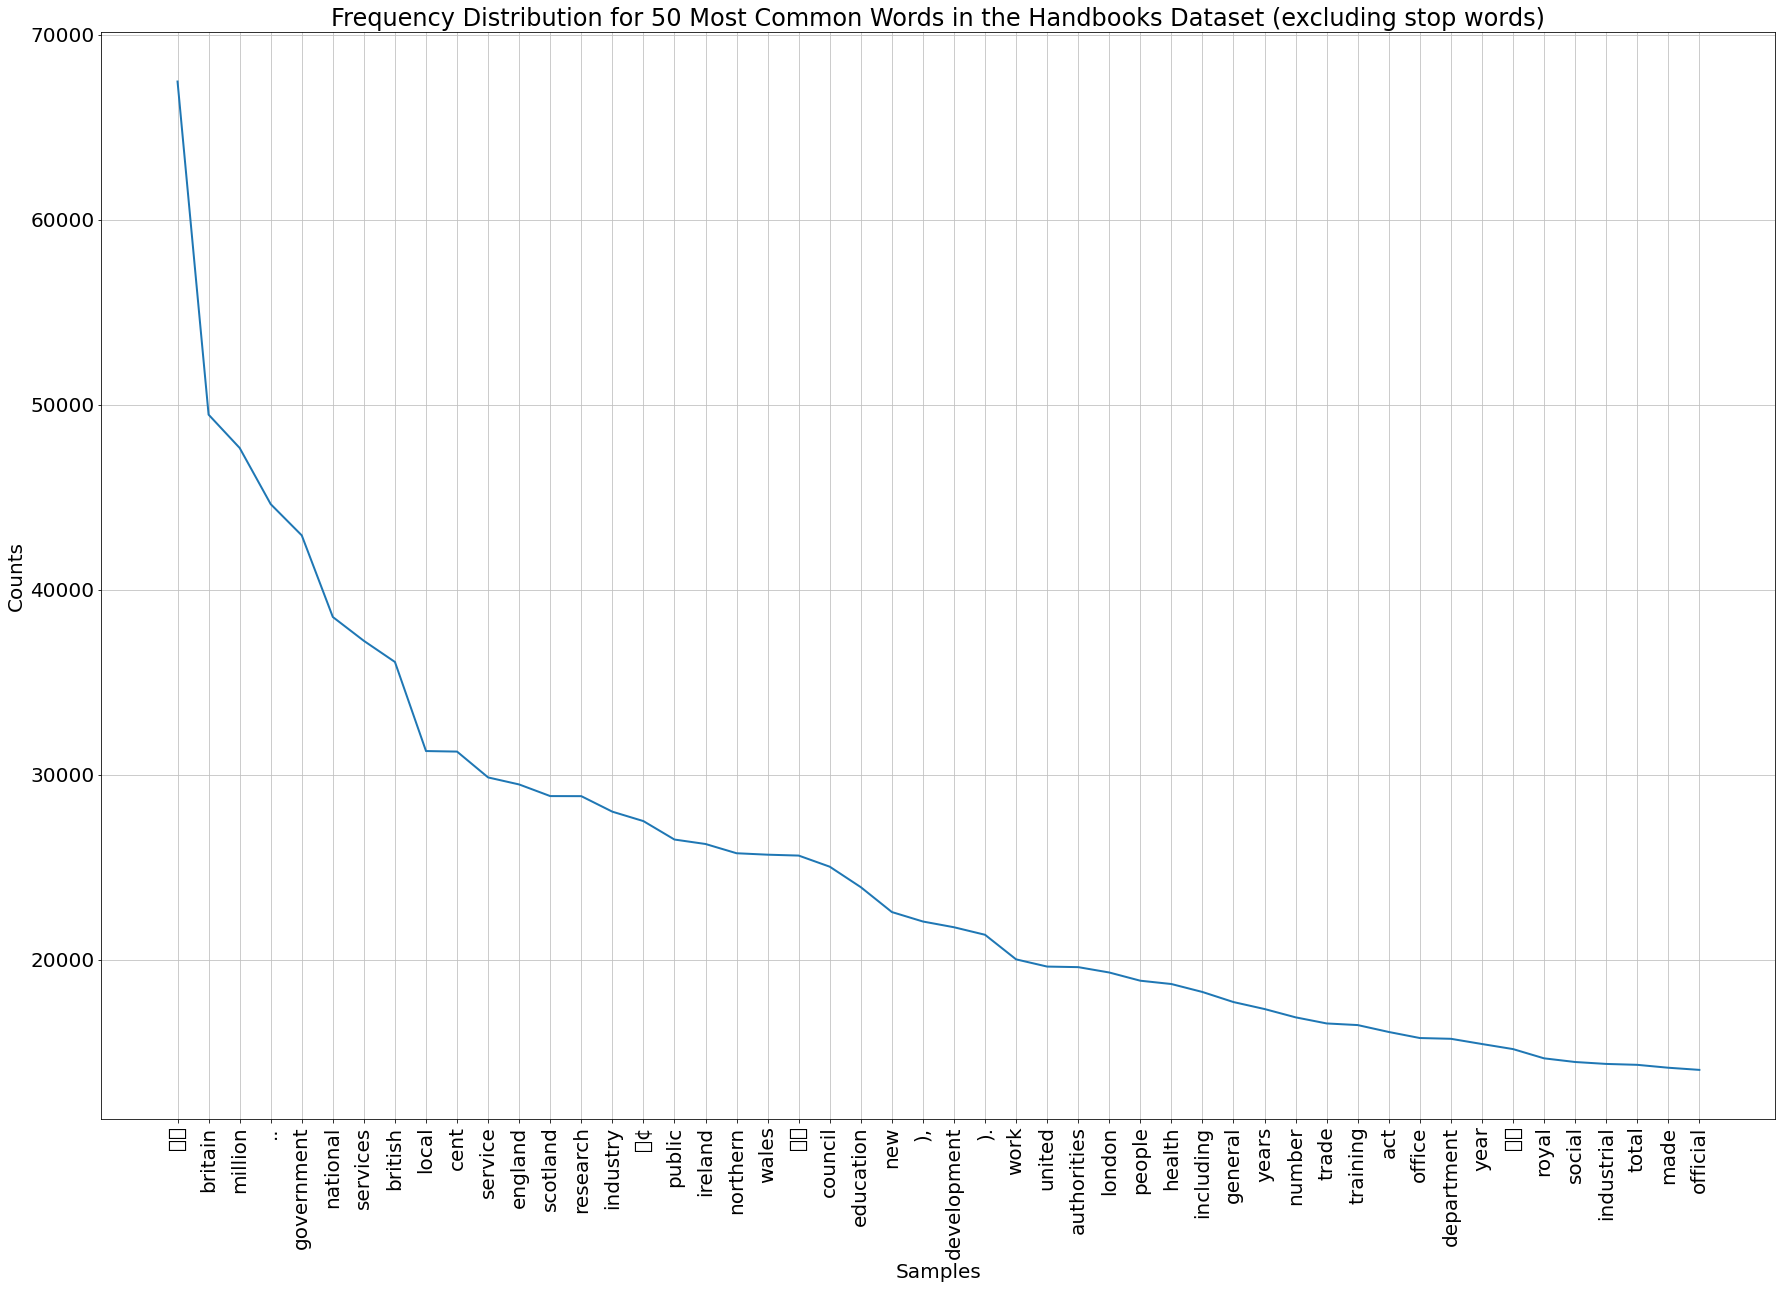

In [30]:
# Visualize the frequency distribution for a select number of tokens
plt.figure(figsize = (30, 20))                # customize the width and height of the plot
plt.rc('font', size=20)                       # customize the font size of the title, axes names, and axes labels
fdist_ft.plot(50, title='Frequency Distribution for 50 Most Common Words in the Handbooks Dataset (excluding stop words)')

Next, let's create the same type of plot using tokens that were recognized by WordNet as English words, excluding the same stop words, punctuation, and digits as above:

In [31]:
rec_min_two_letters = [t for t in lower_recognized if len(t) > 2]
to_exclude = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + ['also', 'per', '000', 'one', 'many', 'may', 'two', 'see'])
filtered_rec_tokens = [t for t in rec_min_two_letters if not t in to_exclude]
fdist_ft_rec = FreqDist(filtered_rec_tokens)
fdist_ft_rec.N()  # count the total tokens after filtering

7222584

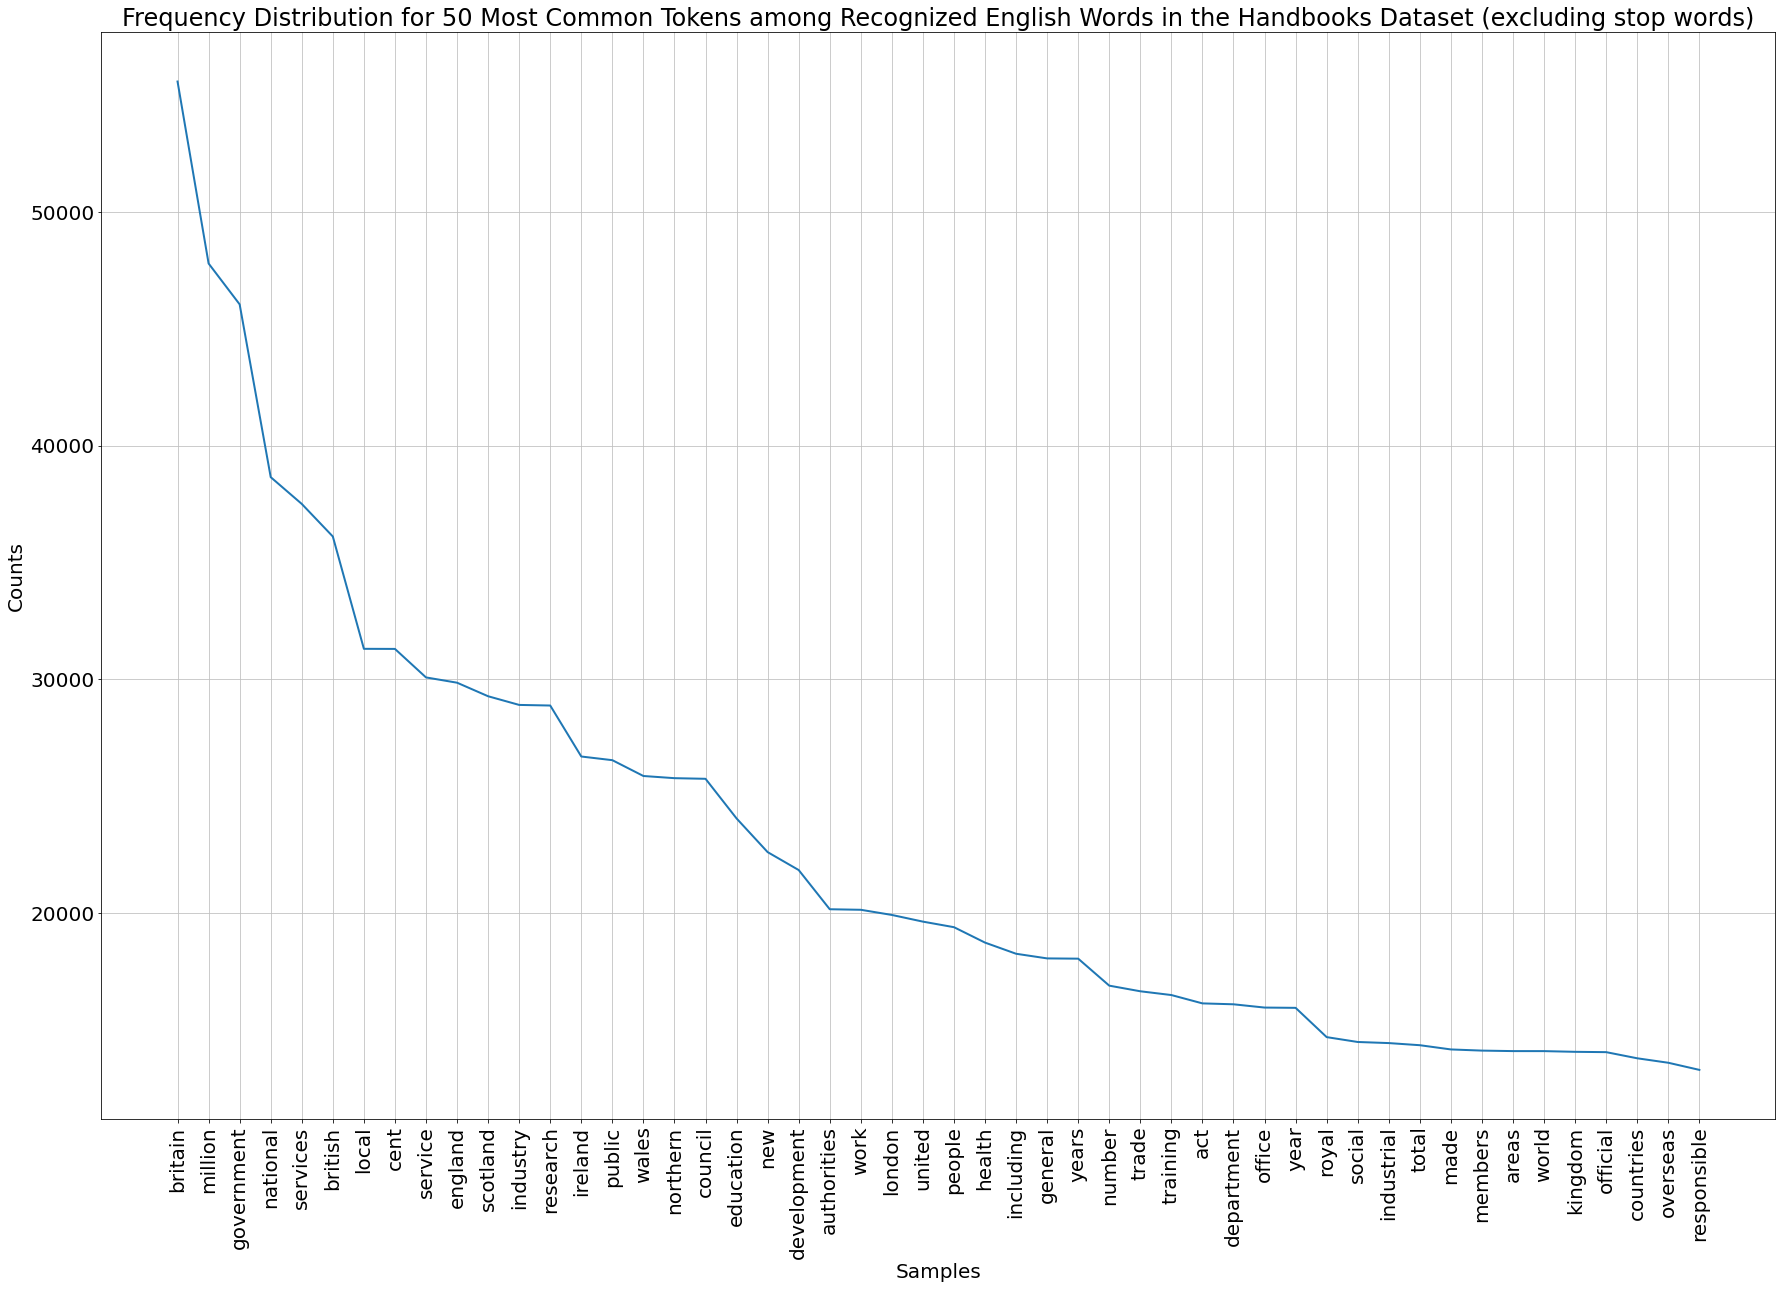

In [32]:
plt.figure(figsize = (30, 20))
plt.rc('font', size=20)
fdist_ft_rec.plot(50, title='Frequency Distribution for 50 Most Common Tokens among Recognized English Words in the Handbooks Dataset (excluding stop words)')

The plots look very similar!  Nearly all the tokens are repeated in each visualization and they appear in a similar order.  It's also reassuring to see that the top 50 tokens are real words or names, which means those outweigh mistakenly spelled words and names that resulted from the imperfect OCR (the digitization process).

Let's make one more frequency distribution, visualizing the occurrences of the top 50 *lemmatized* words in the Handbooks dataset.

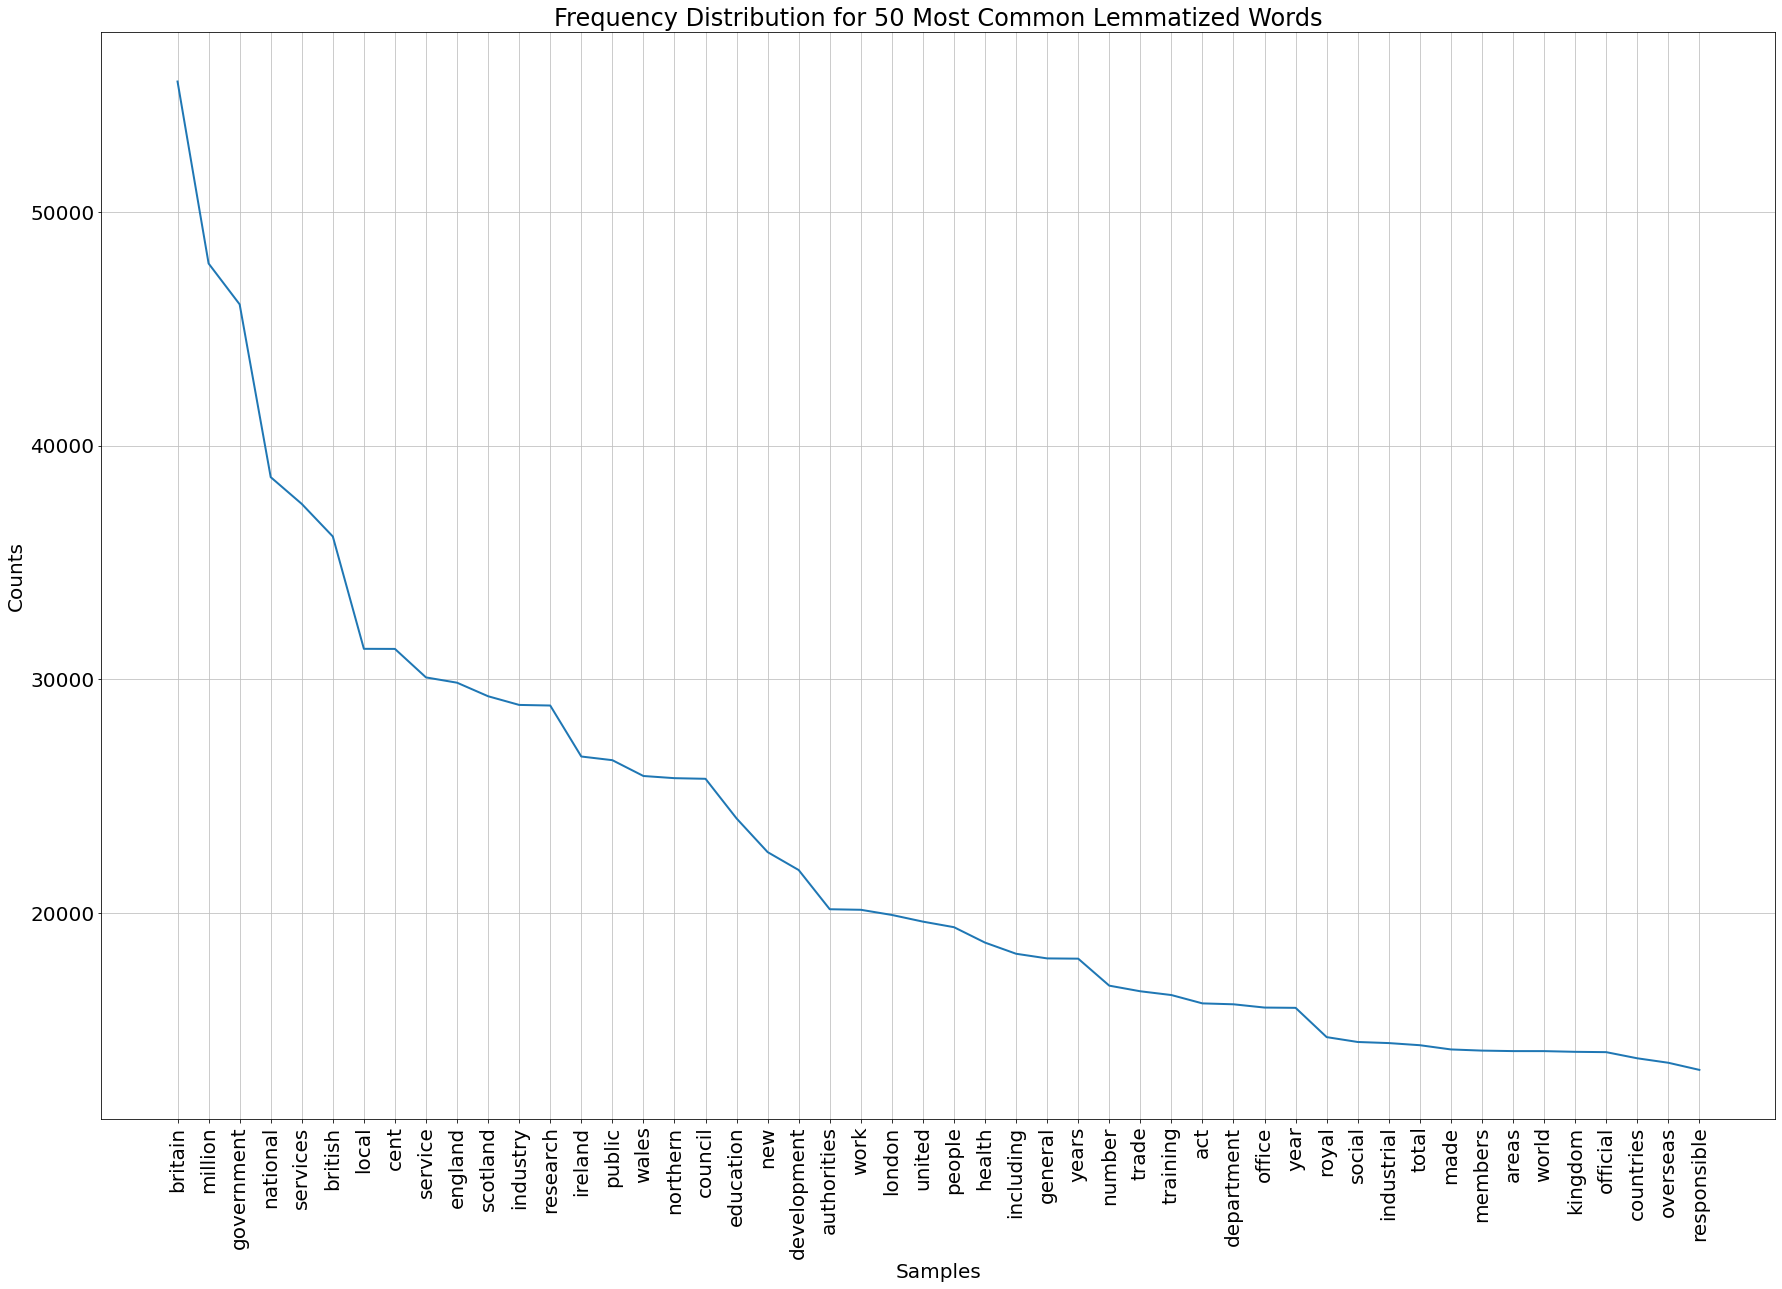

In [33]:
min_two_letters = [t for t in lemmatized if len(t) > 2]
to_exclude = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + ['also', 'per', '000', 'one', 'many', 'may', 'two', 'see'])
filtered_lemma = [t for t in rec_min_two_letters if not t in to_exclude]
fdist_lemma = FreqDist(filtered_lemma)
plt.figure(figsize = (30, 20))
plt.rc('font', size=20)
fdist_lemma.plot(50, title='Frequency Distribution for 50 Most Common Lemmatized Words')

#### 2.2 Uniqueness and Variety

Another way to summarize the Handbooks dataset is to look at the uniqueness and variety of word usage.  We can obtain the **vocabulary** of the text by creating a set of unique tokens that occur in the dataset, as well as creating a set of unique *lemmatized* tokens that occur in the dataset.

In [34]:
# Remove duplicate tokens from the text (obtain the vocabulary of the text)
t_vocab = set(str_tokens)
t_vocab_lower = set(lower_str_tokens)
lemma_vocab = set(lemmatized)
print("Unique tokens:", len(t_vocab))
print("Unique lowercase tokens:", len(t_vocab_lower))
print("Unique lemmatized (lowercase) tokens:", len(lemma_vocab))
print()
rec_vocab = set(recognized)
rec_vocab_lower = set(lower_recognized)
unrec_vocab = set(unrecognized)
unrec_vocab_lower = set(lower_unrecognized)
print("Unique recognized words:", len(rec_vocab))
print("Unique recognized lowercase words:", len(rec_vocab_lower))
print("Unique unrecognized words:", len(unrec_vocab))
print("Unique unrecognized lowercase words:", len(unrec_vocab_lower))

Unique tokens: 86793
Unique lowercase tokens: 70922
Unique lemmatized (lowercase) tokens: 52713

Unique recognized words: 36780
Unique recognized lowercase words: 25602
Unique unrecognized words: 49946
Unique unrecognized lowercase words: 42123


The vocabulary of the entire Handbooks dataset contains 70,922 unique words, 36,780 of which are recognized English words in WordNet. The lemmatized vocabulary of the dataset contains 66,172 words.

In [35]:
print(list(lemma_vocab)[:100])

['collectionâ', 'kvrn', 'wlo', 'dae', 'purbeck', 'submission', 'summer', 'bahaâ', 'lpes', 'latinâ', 'desigâ', 'govefnment', 'corby', 'erbury', 'maynootn', 'canalized', 'ffor', 'bkegness', 'underlies', 'geostationary', 'hydraulic', 'boyfriend', 'mikhail', 'minimum', 'inflammable', 'paccar', 'intereet', 'pharmâ', 'secukr', 'gkinguss', 'cushioned', 'timer', 'ptirsoiâ', 'while', 'build', 'surveg', 'adrian', 'lyness', 'cooos', 'automation', 'gasifier', 'adventure', 'commanding', 'dbbyrtdhe', 'intensive', 'housewifeâ', 'anthracite', 'belle', 'scattered', 'due', 'rosa', 'data', 'firefighting', 'lontroi', 'abpâ', 'sbe', 'thatched', 'whitfield', 'zvith', 'proliferators', 'igjjhns', 'zorastrians', 'natsâ', 'stressed', 'junction', 'kchel', 'shrub', 'dungannon', 'scholastic', 'almshousesâ', 'stoe', 'ballers', 'nd', 'magnatrust', 'airb', 'prosecutâ', 'wrhen', 'rota', 'contempâ', 'hewlett', 'aeo', 'fallon', 'wdiooping', 'eirene', 'alcopopsâ', 'beale', 'llandilo', 'creative', 'pneumatic', 'swqos', 's

We can create a data visualization that illustrates when specific words are used within the Handbooks dataset.  This is called a **Lexical Dispersion Plot**.  We'll pick some place names (the list of `targets`) to see when they appear:

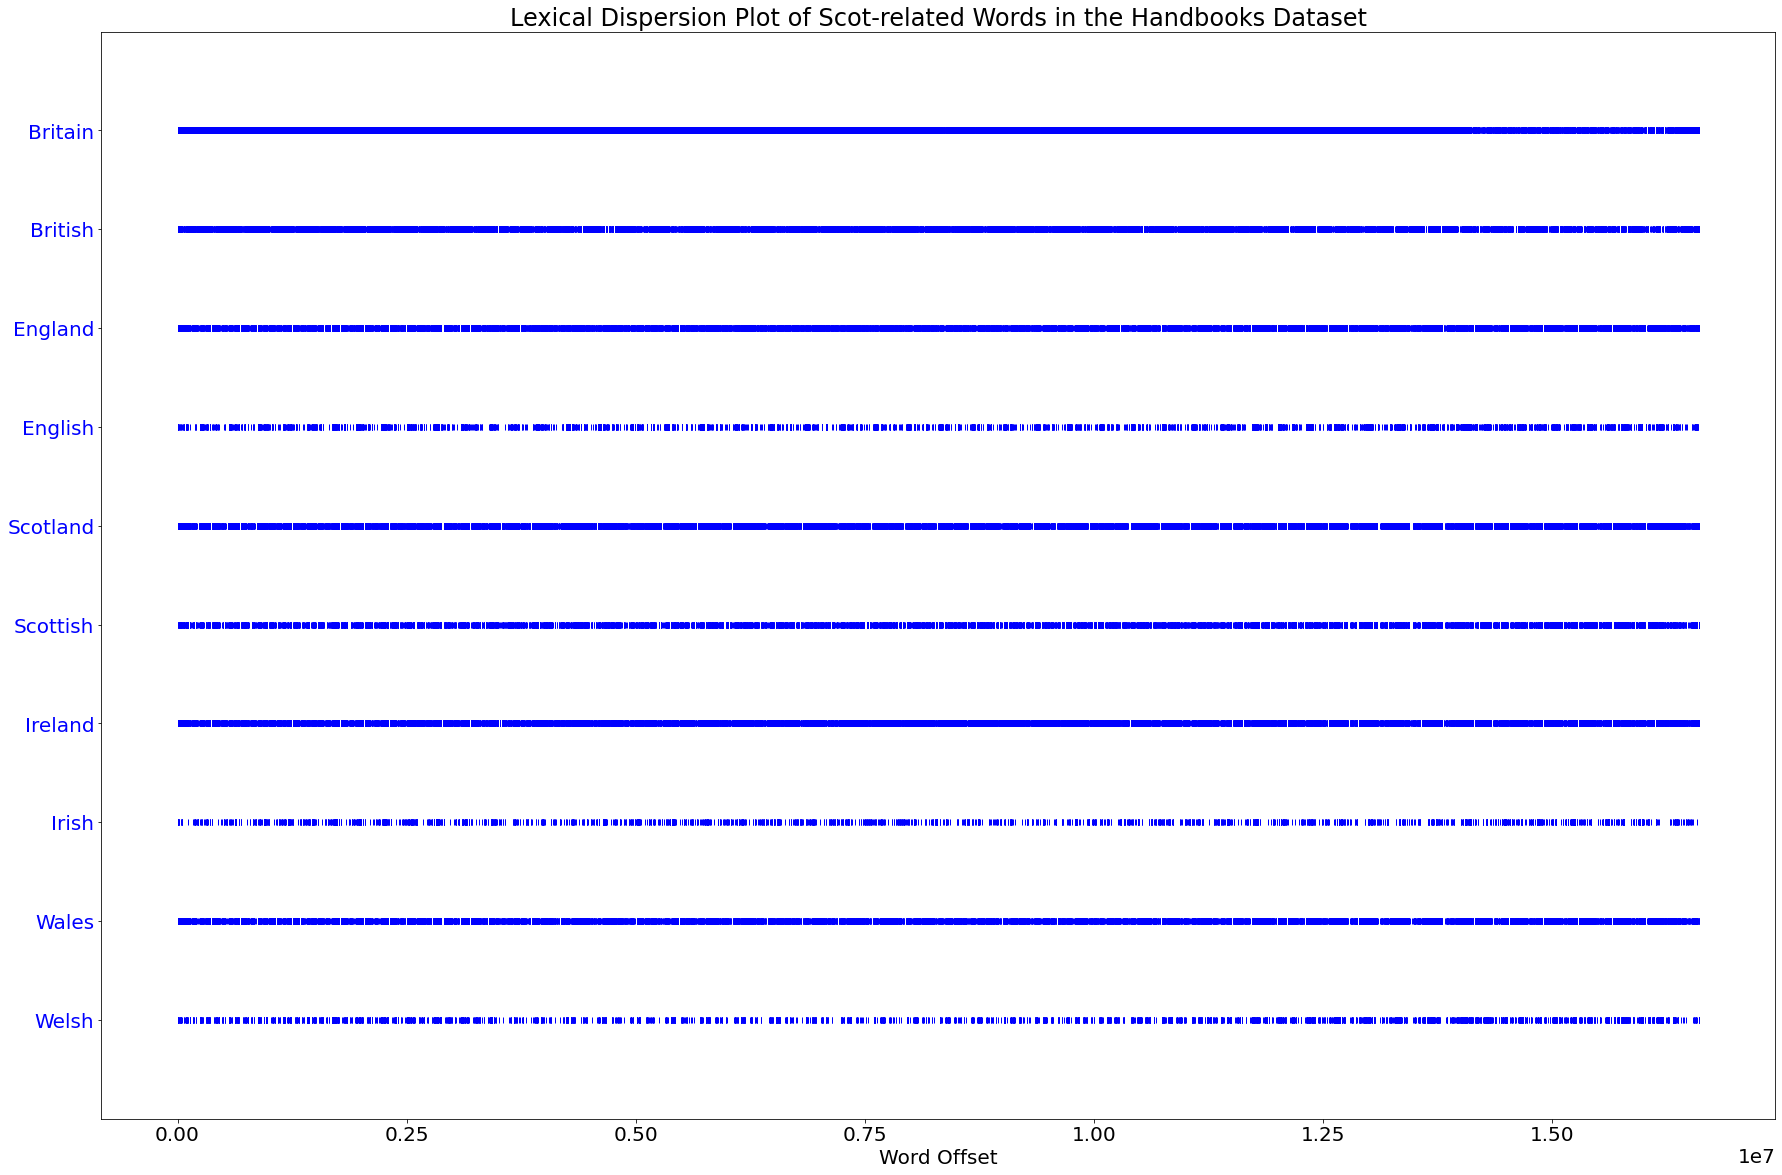

In [36]:
corpus_text = Text(corpus_tokens)
targets = ['Britain', 'British', 'England', 'English', 'Scotland', 'Scottish', 'Ireland', 'Irish', 'Wales', 'Welsh']
plt.figure(figsize=(30,20))
plt.rc('font', size=20)
displt(corpus_text, targets, ignore_case=True, title='Lexical Dispersion Plot of UK and Ireland Place-related Words in the Handbooks Dataset')

Hmmm.  The words we chose occur so frequently across the entire dataset that it's difficult to pick out many patterns, though we can se that `Irish` and `Welsh` occur less often that `British` and `Scottish`.  Since the Handbooks dataset contains multiple volumes, we could try picking a subset of volumes, or even a single volume, and visualizing the lexical dispersion for that subset of the Handbooks dataset.  That may reveal more interesting patterns!

### 3. Exploratory Analysis

#### 3.1 How is Britain and the UK portrayed?

The Handbooks were written for an international audience to impress people with the success and strength of Britain and the UK.  Let's investigate how Britain and the UK are portrayed:

In [37]:
t = Text(corpus_tokens)
t.concordance('Britain', lines=10)
# t.concordance('GB')
# t.concordance('United Kingdom') # no matches
# t.concordance('UK')

Displaying 10 of 49467 matches:
 BRITAIN 1979 3W + L Capita ! Edinburgh Popu
ges and salaries 1973 - 78 318 Maps Britain inside back cover Economic planning
icity 255 Some minerals produced in Britain â ¢ 261 Main railway passenger rou
ween pp 390 and 391 ). Introduction Britain 1979 is the thirtieth official hand
onery Office throughout the world . Britain 1979 is primarily concerned to desc
ember 1 978 THE PHYSICAL BACKGROUND Britain , formally known as the United King
nown as the United Kingdom of Great Britain and Northern Ireland , constitutes 
ope . The largest islands are Great Britain ( comprising the mainlands of Engla
d the Channel Islands between Great Britain and France have a large measure of 
ed Kingdom 244 , 103 94 , 249 Great Britain 229 , 983 88 , 797 England 130 , 44


In [38]:
fdist = FreqDist(str_tokens)
print("Frequency (percentage) of Britain and the UK in Handbooks dataset:")
print(" - Britain:", (fdist.freq('Britain'))*100, "%")
print(" - GB:", (fdist.freq('GB'))*100, "%")
print(" - UK:", (fdist.freq('UK'))*100, "%")

Frequency (percentage) of Britain and the UK in Handbooks dataset:
 - Britain: 0.2340547245706578 %
 - GB: 0.0014331478671387623 %
 - UK: 0.06163740154635451 %


In [39]:
# visualizations go here - frequency of words over time and per volume

#### 3.2 How is Scotland portrayed?
How does the portrayal of Britain and the UK compare or contrast with the portrayal of Scotland?

In [40]:
t.concordance('Scotland', lines=10)
# t.concordance('Ireland')  # re.search(.{20}'(?<!Northern )Ireland.{20}')
# t.concordance('Wales')
# t.concordance('England')

Displaying 10 of 28849 matches:
e mainlands of England , Wales and Scotland ) and Ireland ( comprising Norther
 north Wales is Anglesey . Western Scotland is fringed by numerous islands and
 are not part of England , Wales , Scotland or Northern Ireland . TABLE 1 : Ar
41 50 , 363 Wales 20 , 768 8 , 019 Scotland 78 , 775 30 , 415 Northern Ireland
hich comprises England , Wales and Scotland , or to the United Kingdom ( Great
District , the southern uplands of Scotland and the southern border counties o
nes range in northern England . In Scotland similar strata of a partly volcani
on the north - western seaboard of Scotland and in the Outer Hebrides , formin
nd rocky land . On the mainland of Scotland a cover of red sandstone between 8
Inner 1 The highest peaks are : in Scotland , Ben Nevis , 1 , 342 metres ( 4 ,


In [41]:
scot_strings = [s for s in lower_str_tokens if (re.search('scot$', s) or re.search('scot[tcls]+', s))]
print("Total tokens related to Scotland:", len(scot_strings))
unique_scot = set(scot_strings)
print("Unique tokens related to Scotland:", len(unique_scot))
print(unique_scot)

Total tokens related to Scotland: 43029
Unique tokens related to Scotland: 45
{'scottish', 'scottishfa', 'scottishsportsassociation', 'sportscotland', 'scotland1', 'visitscotland', 'scotland12', 'scotch', 'scotlandâ', 'scottishpower', 'scotthorne', 'scotlan', 'rgelstotscotland', 'inpscotland', 'scottls', 'scottishdevelopmentinternational', 'scottâ', 'scotla7id', 'bescot', 'scotstoun', 'scottishtelecom', 'communitiesscotland', 'scots', 'scotlandistheplace', 'scott', 'scottisharts', 'scottishâ', 'scotland', 'inscotland', 'scotlnd', 'nhsscotland', 'nhsscotlandâ', 'scotlandfa', 'scottishnessâ', 'scottishsecretary', 'scottisn', 'scottis', 'sportscotlandâ', 'scotsâ', 'scotland4', 'scot', 'scotlancj', 'scotland5', 'ascot', 'scotsman'}


In [42]:
fdist = FreqDist(str_tokens)
print("Frequency (percentage) of Nations in Handbooks dataset:")
print(" - Scotland:", (fdist.freq('Scotland'))*100, "%")

Frequency (percentage) of Nations in Handbooks dataset:
 - Scotland: 0.17258592865573139 %


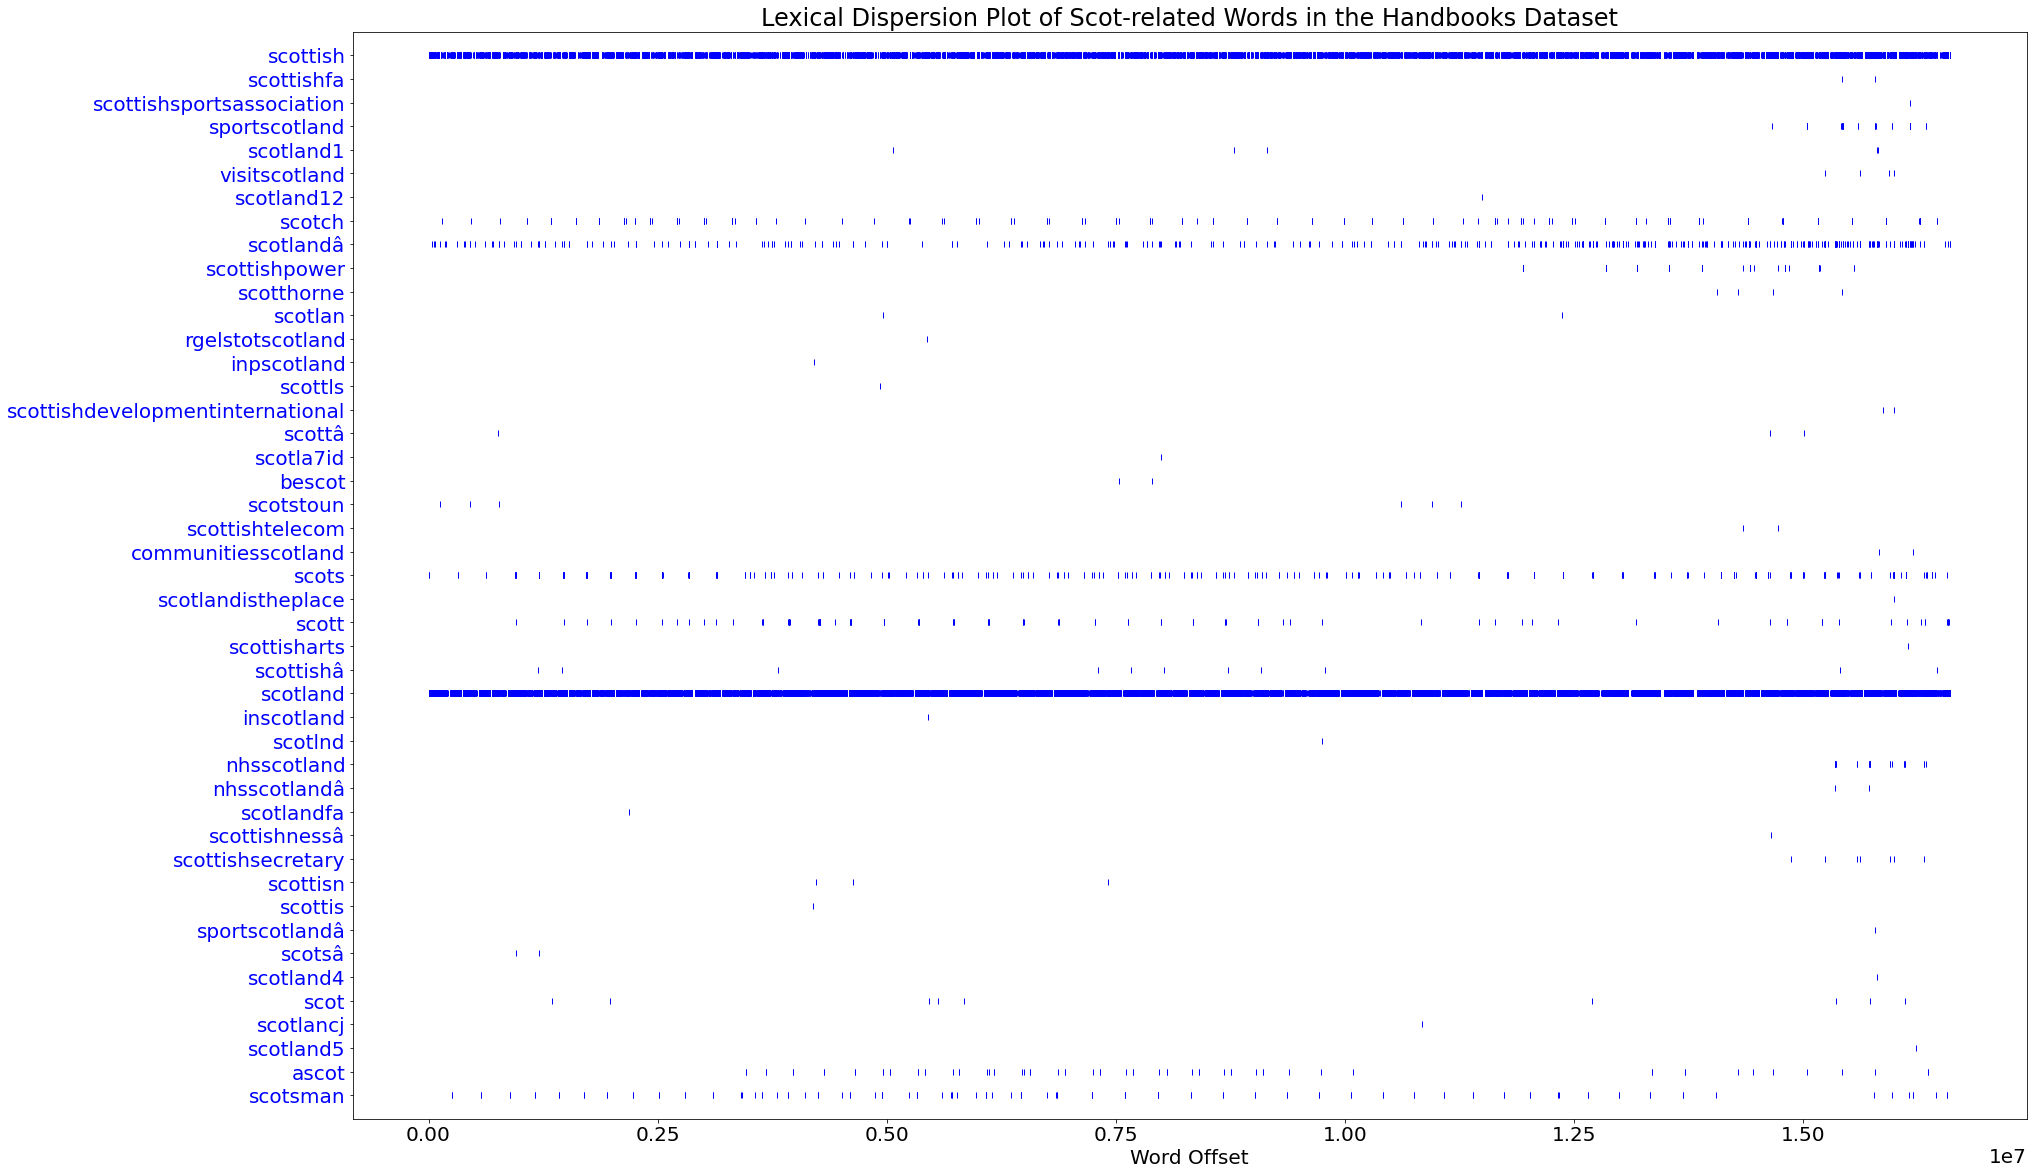

In [43]:
# corpus_text = Text(corpus_tokens)
targets = list(unique_scot)
plt.figure(figsize=(30,20))
plt.rc('font', size=20)
displt(corpus_text, targets, ignore_case=True, title='Lexical Dispersion Plot of Scot-related Words in the Handbooks Dataset')

#### 3.3 Identifying Tables to Transform to Dataframes
The Handbooks contain many tables of statistics.  Could we identify where those are in the text and recreate the tables as DataFrames?

In [44]:
t = Text(str_tokens)
t.concordance('TABLE')

Displaying 25 of 5617 matches:
les , Scotland or Northern Ireland . TABLE 1 : Area of the United Kingdom Total
 population was 55 , 852 , 000 ( see Table 2 , below ). The populations of the 
00 respectively . In 1975 , 1976 and TABLE 2 : Populations 1901 - 77â  thousa
 population by country , is shown in Table 2 on p 7 . The standard regions of E
shire and Humberside 4 , 875 , 900 . Table 3 gives figures of some of Britainâ 
t Wales ; the Bristol area ; and the TABLE 3 : Size and Population of Some of t
Parliament ; the other Clerks at the Table ; the Gentleman Usher of the Black R
in the House of Commons are given in Table 4 . TABLE 4 : Percentages of Votes C
se of Commons are given in Table 4 . TABLE 4 : Percentages of Votes Cast , and 
 in crime since the early 1950s . As Table 5 shows , there has been a rise in t
hom 49 per cent were aged under 21 . TABLE 5 : Known Indictable Offences per 10
r 3 and in other relevant chapters . TABLE 6 : Gross Domestic Product by Indust
nd health

In [45]:
tables = [s for s.lower() in handbooks_sents if re.search('table (\d){1}(\d)* :', s)]
print("Tables in Handbooks:", len(tables))

Tables in Handbooks: 0
